## Visualising Food by Super Group using a network Graph

Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import dash
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import dash_bootstrap_components as dbc
import io
import base64
import matplotlib.cm as cm
import squarify

In [2]:
%load_ext watermark

In [3]:
%watermark --iversions

squarify                 : 0.4.3
pandas                   : 1.5.3
dash                     : 2.12.0
dash_bootstrap_components: 1.4.2
plotly                   : 5.15.0
matplotlib               : 3.7.1



Import Dataset

In [4]:
pd.set_option('display.max_rows', None)
Retail = pd.read_csv(r'C:\Users\medekar\Desktop\Product_Weight_Project\Data\Processed\ReducedwithWeights\dp_full.csv', index_col=0)
Retail.head()

,Food Code,Food Name,Food sub-group codes,Food Group,Sale format(s),Similarity Score,Product Weight,Source,Purchase Date,Pack Size
0,17-208,"beer, bitter, best, premium",QA,Alcoholic beverages,"can, can multipack, bottle, bottle multipack",0.707107,574g,FPS,NaN,1 pint
1,17-224,"cider, sweet",QC,Alcoholic beverages,"can, can multipack, bottle, bottle multipack",0.609864,25g,FPS,NaN,NaN
2,17-234,port,QF,Alcoholic beverages,bottle,0.000000,NaN,NaN,NaN,NaN
3,17-236,"sherry, medium",QF,Alcoholic beverages,bottle,0.000000,NaN,NaN,NaN,NaN
4,17-247,"spirits, 40% volume",QK,Alcoholic beverages,"bottle, miniature",1.000000,29g,FPS,NaN,1 miniature


                                            Creating and Visualising Graph

### Food Products in Super Group

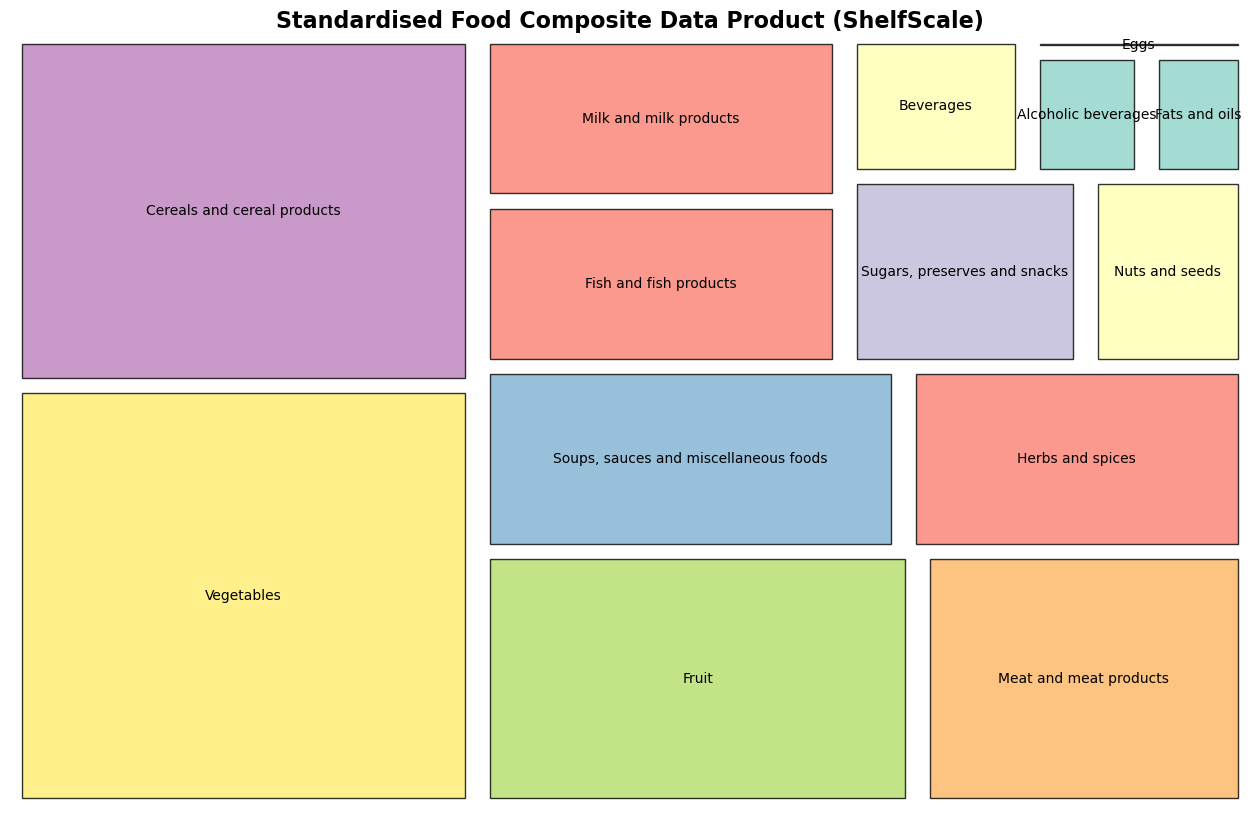

In [5]:
# Count the occurrences of each super group
super_group_counts = Retail['Food Group'].value_counts()

# Create labels and sizes for the treemap
labels = super_group_counts.index
sizes = super_group_counts.values

# Custom colors for the treemap (replace with your preferred colors)
# For shading one color, we'll use the 'viridis' colormap from Matplotlib
cmap = cm.Set3
normalize = plt.Normalize(vmin=sizes.min(), vmax=sizes.max())
colors = [cmap(normalize(value)) for value in sizes]

# Add box outlines
plt.figure(figsize=(16, 10))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=colors, linewidth=1, edgecolor='black', pad=True)

# Add title
plt.title('Standardised Food Composite Data Product (ShelfScale)', fontsize=16, fontweight='bold')


# Remove axes
plt.axis('off')

# Show the plot
plt.show()


                                            Creating an interactive Version

In [6]:
# Count the occurrences of each super group
super_group_counts = Retail['Food Group'].value_counts()

# Create labels and sizes for the treemap
labels = super_group_counts.index
sizes = super_group_counts.values
#print(labels)

# Custom colors for the treemap (replace with your preferred colors)
cmap = cm.Set3
colors = [f'rgb{tuple(int(255 * x) for x in cmap(i)[:3])}' for i in range(len(labels))]

# Create the Plotly treemap
fig = go.Figure(go.Treemap(
    labels=labels,
    parents=[''] * len(labels),
    values=sizes,
    customdata=[f"{size} products" for size in sizes],  # Data for hover info
    texttemplate="%{label}<br>%{customdata}",
    textfont=dict(size=15, family="Arial"),
    marker=dict(
        colors=colors,
        line=dict(width=0.5, color='black')
    )
))

# Customize the layout
fig.update_layout(
    margin=dict(t=50, l=10, r=10, b=10)
)

# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.ZEPHYR])

# Define the app layout
app.layout = html.Div([
    html.Div([
        html.H1('ShelfScale Dashboard', className='header'),
        html.P("Click on a treemap box to see more details:", className='intro-text'),
    ], className='header-container'),
    html.Div([
        dcc.Graph(id='treemap', figure=fig, config={'displayModeBar': False}),
        dbc.Modal([
            dbc.ModalHeader("First Ten Product Weight as Purchased"),
            dbc.ModalBody(id='table-modal-content'),
            dbc.ModalFooter([
                html.A(
                    dbc.Button("Download", id="download-button", color="primary"),
                    id='download-link-modal',
                    download="data.csv",
                    href="",
                    target="_blank"
                ),
                dbc.Button("Close", id="close-table-modal", className="ml-auto", n_clicks=0)
            ]),
        ],
        id="table-modal-xl", size="xl", is_open=False, fullscreen=True),
    ], className='treemap-container'),
    html.A(
        dbc.Button("Download Full Dataset", id='download-button-csv', n_clicks=0),
        id='download-link',
        download="Weightdata.csv",
        href="",
        target="_blank"
    ),
    html.Div([
        html.Div(id='table-container', className='table-container', children=[
            html.Table(id='details-table', className='details-table')
        ]),
    ], className='table-container'),
])

# When I click a box I want the information of the box to show in expanded box with the option to download

In [7]:
# Define constants
MAX_ROWS = 10
TABLE_STYLE = {'max-height': '500px', 'overflowY': 'scroll', 'max-width': '100%'}
TABLE_MODAL_WIDTH = '100%'  
expanded_boxes = []

# Function to generate the CSV download link
def generate_csv_link(dataframe, filename):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, index=False, encoding='utf-8')
    
    csv_data = csv_buffer.getvalue().encode('utf-8')
    b64 = base64.b64encode(csv_data).decode('utf-8')
    
    return f"data:text/csv;charset=utf-8;base64,{b64}"


# Callback function
@app.callback(
    [Output('treemap', 'clickData'),
     Output('table-modal-xl', 'is_open'),
     Output('table-modal-content', 'children'),
     Output('download-link', 'href'),
     Output('download-button-csv', 'n_clicks')],
    
    [Input('treemap', 'clickData'),
     Input('download-button', 'n_clicks'),
     Input('close-table-modal', 'n_clicks'),
     Input('download-button-csv', 'n_clicks')],
    prevent_initial_call=True
)


def toggle_table_modal(click_data, download_clicks, close_clicks, download_table_clicks):
        
    global expanded_boxes
    global products1  
    
    ctx = dash.callback_context
    trigger_id = ctx.triggered[0]['prop_id'].split('.')[0]
    
    if trigger_id == 'close-table-modal': 
        expanded_boxes = [] # Reset expanded boxes
        return dash.no_update, False, None, dash.no_update, dash.no_update
    
    elif trigger_id == 'treemap':
        if not click_data or 'points' not in click_data:
            return dash.no_update, False, None, dash.no_update, dash.no_update
        
        super_group = click_data['points'][0]['label']
        
        if super_group in expanded_boxes:
            expanded_boxes.remove(super_group)  # Minimize expanded box
            return dash.no_update, False, None, dash.no_update, dash.no_update
            
        expanded_boxes.append(super_group)
        products1 = Retail[Retail['Food Group'] == super_group]
        products = products1.head(MAX_ROWS)
        
        table = dbc.Table.from_dataframe(
            products,
            striped=True,
            bordered=True,
            hover=True,
            responsive=True,
            style={**TABLE_STYLE, 'width': TABLE_MODAL_WIDTH},
        )
        
        filename = f"{super_group}_data"  # Construct the filename
        csv_link = generate_csv_link(products1, filename)  # Generate CSV link
        
        return click_data, True, table, csv_link, dash.no_update
           
    elif trigger_id == 'download-button':
        if not products1.empty:
            csv_link = generate_csv_link(products1, "data")  # Generate CSV link
            return dash.no_update, dash.no_update, dash.no_update, csv_link, dash.no_update
    
    elif trigger_id == 'download-button-csv':
        if not products1.empty and click_data and 'points' in click_data:
            super_group_label = click_data['points'][0]['label']
            filename = f"{super_group_label}_Weightdata"

            csv_link = generate_csv_link(products1, filename)  # Generate CSV link
            return dash.no_update, dash.no_update, dash.no_update, csv_link, 0
        else:
            return dash.no_update, dash.no_update, dash.no_update, dash.no_update, dash.no_update

    
    elif trigger_id == 'close-table-modal':
        expanded_boxes = []  # Reset the expanded boxes list
        return dash.no_update, False, None, dash.no_update, dash.no_update
    
    return dash.no_update, False, None, dash.no_update, dash.no_update

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

                                                       End of Notebook